In [1]:
import wave
import numpy
import matplotlib.pyplot as plt
import scipy.signal as signal

In [2]:
# extracts everything (hopefully) relevant from the wav file
def extract_data(wav_file):
    try:
        with wave.open(wav_file, 'rb') as input:
            frames = input.readframes(-1)
            rate = input.getframerate()
            channels = input.getnchannels()
            width = input.getsampwidth()
        return frames, rate, channels, width
    except FileNotFoundError:
        print(f"Error: File '{wav_file}' not found.")
        return None
    except IOError as e:
        print(f"Error: Unable to open file '{wav_file}': {e}")
        return None

In [3]:
# sample.wav was pulled from https://apt.open-weather.community/
extracted_data = extract_data('sample.wav')

if extracted_data is None:
    print("Error: no data")
else:
    frames, rate, channels, width = extracted_data
    print("# Frames:", len(frames))
    print("Rate:", rate)
    print("Channels:", channels)
    print("Width:", width)

# Frames: 19840702
Rate: 11025
Channels: 1
Width: 2


In [4]:
# Convert frames to numpy array of integers
audio_data = numpy.frombuffer(frames, dtype=numpy.int16)

print(audio_data.shape)

(9920351,)


## Looking at periodicity

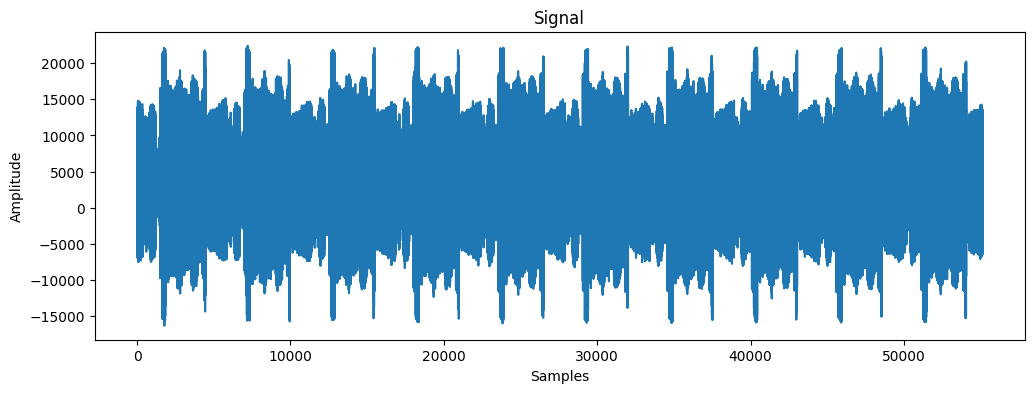

In [5]:
slice = audio_data[20*rate:25*rate]
plt.figure(figsize=(12,4))
plt.plot(slice)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Signal")
plt.show()

## Back to the math

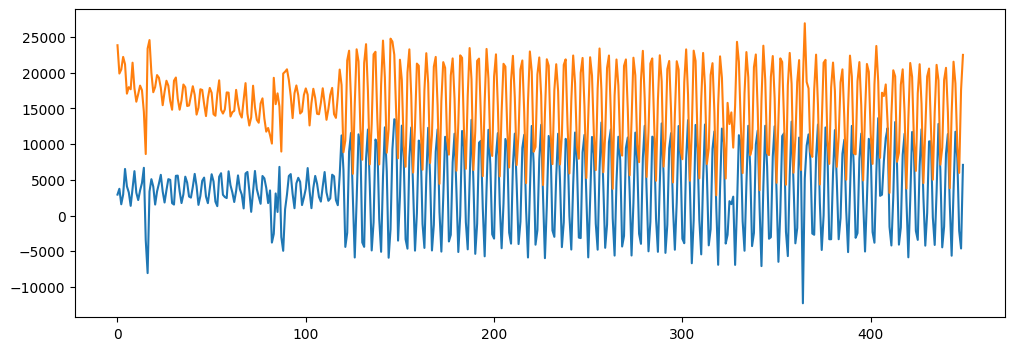

In [6]:
# plot a sample of signal and envelope
def plot_sig_env(signal, envelope):
    sample_size = 450
    start_index = 0
    sig = signal[start_index:start_index + sample_size]
    env = envelope[start_index:start_index + sample_size]
    plt.figure(figsize=(12,4))
    plt.plot(sig.real)
    #plt.plot(sig.imag)
    #plt.plot(sig)
    plt.plot(env)
    plt.show()

def hilbert_transform(audio_data):
    analytical_signal = signal.hilbert(audio_data)
    amplitude_envelope = numpy.abs(analytical_signal)

    plot_sig_env(analytical_signal, amplitude_envelope)
    
    return amplitude_envelope
    
data_am = hilbert_transform(audio_data)

## Converting this to an image

In [7]:
print(data_am.shape, type(data_am[0]))
print(min(data_am), max(data_am))

data_scaled = (data_am / max(data_am)) * 255
print(min(data_scaled), max(data_scaled))

(9920351,) <class 'numpy.float64'>
1.099498192836281 36190.53759759632
0.00774710898994419 255.0


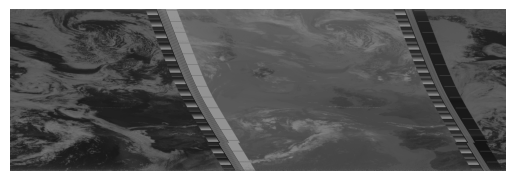

In [8]:
from PIL import Image

COLS = int(0.5 * rate)
ROWS = data_am.shape[0] // COLS
SCALE = 2 ** 15
image = Image.new('L', (COLS, ROWS))

col, row = 0, 0
for p in range(data_am.shape[0]):
    color = int((data_am[p] / SCALE) * 255)
    image.putpixel((col, row), color)
    
    col += 1
    if col >= COLS:
        col = 0
        row += 1
        if row >= ROWS:
            break
plt.imshow(image, cmap="gray")
plt.axis('off')
plt.show()

In [9]:
image.save("greyscale9.jpg")

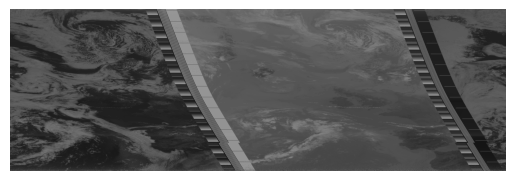

In [10]:
# Trying a simpler way to create the image
d = (data_am / SCALE * 255)
d[d < 0] = 0
d[d > 255] = 255

d = d[:ROWS * COLS]
d = d.reshape((ROWS, COLS))

plt.imshow(d, cmap="gray")
plt.axis('off')
plt.show()

In [ ]:
cv